In [1]:
import torch
import torchvision
import torchvision.transforms as transforms

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=64,
                                         shuffle=False, num_workers=2)

# Class names
classes = ['plane', 'car', 'bird', 'cat', 'deer',
           'dog', 'frog', 'horse', 'ship', 'truck']

100%|██████████| 170M/170M [00:50<00:00, 3.39MB/s] 


Extracting ./data\cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [3]:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

def train(model, optimizer, criterion, epochs=10):
    model.train()
    train_loss_list = []
    train_acc_list = []

    for epoch in range(epochs):
        running_loss = 0.0
        correct = 0
        total = 0

        for inputs, labels in trainloader:
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            
            # torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)

            optimizer.step()

            running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        epoch_loss = running_loss / len(trainloader)
        epoch_acc = 100 * correct / total

        train_loss_list.append(epoch_loss)
        train_acc_list.append(epoch_acc)

        print(f"Epoch {epoch+1}/{epochs}, Loss: {epoch_loss:.4f}, Accuracy: {epoch_acc:.2f}%")

    return train_loss_list, train_acc_list

def test(model):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in testloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    print(f"Test Accuracy: {100 * correct / total:.2f}%")

def plot_training_curves(loss_list, acc_list):
    epochs = range(1, len(loss_list) + 1)
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(epochs, loss_list, label='Training Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training Loss Curve')
    plt.grid(True)

    plt.subplot(1, 2, 2)
    plt.plot(epochs, acc_list, label='Training Accuracy', color='orange')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy (%)')
    plt.title('Training Accuracy Curve')
    plt.grid(True)

    plt.tight_layout()
    plt.show()

Using device: cpu


In [4]:
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, 3, stride, 1)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(out_channels, out_channels, 3, 1, 1)
        self.bn2 = nn.BatchNorm2d(out_channels)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, 1, stride),
                nn.BatchNorm2d(out_channels)
            )

    def forward(self, x):
        out = self.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)  # 残差连接
        out = self.relu(out)
        return out

In [5]:

# 数据增强
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),      # 随机裁剪（带填充）
    transforms.RandomHorizontalFlip(),         # 水平翻转
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),  # 色彩扰动
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# 测试集不变
transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

In [6]:
trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=False, transform=transform_train)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=False, transform=transform_test)
testloader = torch.utils.data.DataLoader(testset, batch_size=64,
                                         shuffle=False, num_workers=2)

In [7]:
class ResNetNEO3663(nn.Module):
    def __init__(self):
        super(ResNetNEO3663, self).__init__()
        self.conv1 = nn.Conv2d(3, 64, 3, padding=1)  # [3, 32, 32] -> [64, 32, 32]
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU()

        # Residual blocks
        self.layer1 = self._make_layer(64, 128, num_blocks=3, stride=2)
        self.layer2 = self._make_layer(128, 256, num_blocks=6, stride=2)
        self.layer3 = self._make_layer(256, 256, num_blocks=6, stride=2)
        self.layer4 = self._make_layer(256, 512, num_blocks=3, stride=2)


        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))  # [512, 1, 1]
        self.fc = nn.Sequential(
            nn.Linear(512, 512),
            nn.BatchNorm1d(512),
            nn.GELU(),
            nn.Dropout(0.5),
            nn.Linear(512, 10)
        )

    def _make_layer(self, in_ch, out_ch, num_blocks, stride):
        layers = []
        layers.append(ResidualBlock(in_ch, out_ch, stride))  # 第一个 block 做降采样
        for _ in range(1, num_blocks):
            layers.append(ResidualBlock(out_ch, out_ch))  # 之后保持通道一致
        return nn.Sequential(*layers)

    def forward(self, x):
        out = self.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = self.avgpool(out)
        out = out.view(out.size(0), -1)
        out = self.fc(out)
        return out

Epoch 1/100, Loss: 1.8063, Accuracy: 32.38%
Epoch 2/100, Loss: 1.3042, Accuracy: 52.54%
Epoch 3/100, Loss: 1.0458, Accuracy: 62.96%
Epoch 4/100, Loss: 0.8754, Accuracy: 69.48%
Epoch 5/100, Loss: 0.7597, Accuracy: 73.78%
Epoch 6/100, Loss: 0.6698, Accuracy: 76.99%
Epoch 7/100, Loss: 0.6013, Accuracy: 79.34%
Epoch 8/100, Loss: 0.5501, Accuracy: 81.21%
Epoch 9/100, Loss: 0.5120, Accuracy: 82.51%
Epoch 10/100, Loss: 0.4617, Accuracy: 84.20%
Epoch 11/100, Loss: 0.4312, Accuracy: 85.31%
Epoch 12/100, Loss: 0.3969, Accuracy: 86.51%
Epoch 13/100, Loss: 0.3707, Accuracy: 87.32%
Epoch 14/100, Loss: 0.3441, Accuracy: 88.26%
Epoch 15/100, Loss: 0.3228, Accuracy: 89.09%
Epoch 16/100, Loss: 0.2998, Accuracy: 89.88%
Epoch 17/100, Loss: 0.2824, Accuracy: 90.43%
Epoch 18/100, Loss: 0.2605, Accuracy: 91.15%
Epoch 19/100, Loss: 0.2502, Accuracy: 91.46%
Epoch 20/100, Loss: 0.2370, Accuracy: 91.78%
Epoch 21/100, Loss: 0.2231, Accuracy: 92.45%
Epoch 22/100, Loss: 0.2055, Accuracy: 92.99%
Epoch 23/100, Loss:

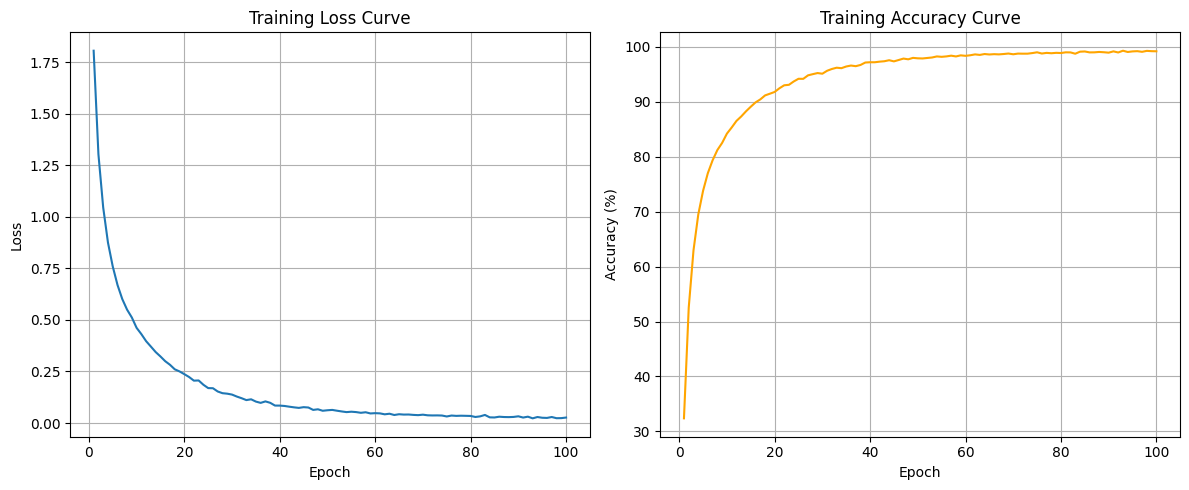

Test Accuracy: 92.57%


In [7]:
model = ResNetNEO3663().to(device)
criterion = nn.CrossEntropyLoss()

optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=20, gamma=0.5)

train_losses, train_accuracies = train(model, optimizer, criterion, epochs=100)
plot_training_curves(train_losses, train_accuracies)
test(model)

In [8]:
torch.save(model.state_dict(), "model_res3663_steplr_100epo.pth")

Epoch 1/50, Loss: 1.9680, Accuracy: 27.28%
Epoch 2/50, Loss: 1.5681, Accuracy: 42.47%
Epoch 3/50, Loss: 1.4107, Accuracy: 48.73%
Epoch 4/50, Loss: 1.2078, Accuracy: 56.61%
Epoch 5/50, Loss: 1.0531, Accuracy: 62.39%
Epoch 6/50, Loss: 1.0040, Accuracy: 64.69%
Epoch 7/50, Loss: 0.9004, Accuracy: 68.44%
Epoch 8/50, Loss: 0.9503, Accuracy: 66.62%
Epoch 9/50, Loss: 0.8067, Accuracy: 71.91%
Epoch 10/50, Loss: 0.7008, Accuracy: 75.57%
Epoch 11/50, Loss: 0.7424, Accuracy: 74.41%
Epoch 12/50, Loss: 0.7316, Accuracy: 74.83%
Epoch 13/50, Loss: 0.6391, Accuracy: 77.96%
Epoch 14/50, Loss: 0.6694, Accuracy: 77.13%
Epoch 15/50, Loss: 0.6391, Accuracy: 78.16%
Epoch 16/50, Loss: 0.5855, Accuracy: 79.93%
Epoch 17/50, Loss: 0.5066, Accuracy: 82.52%
Epoch 18/50, Loss: 0.4966, Accuracy: 82.94%
Epoch 19/50, Loss: 0.4568, Accuracy: 84.49%
Epoch 20/50, Loss: 0.6561, Accuracy: 77.57%
Epoch 21/50, Loss: 0.6319, Accuracy: 78.17%
Epoch 22/50, Loss: 0.6075, Accuracy: 79.09%
Epoch 23/50, Loss: 0.5357, Accuracy: 81.5

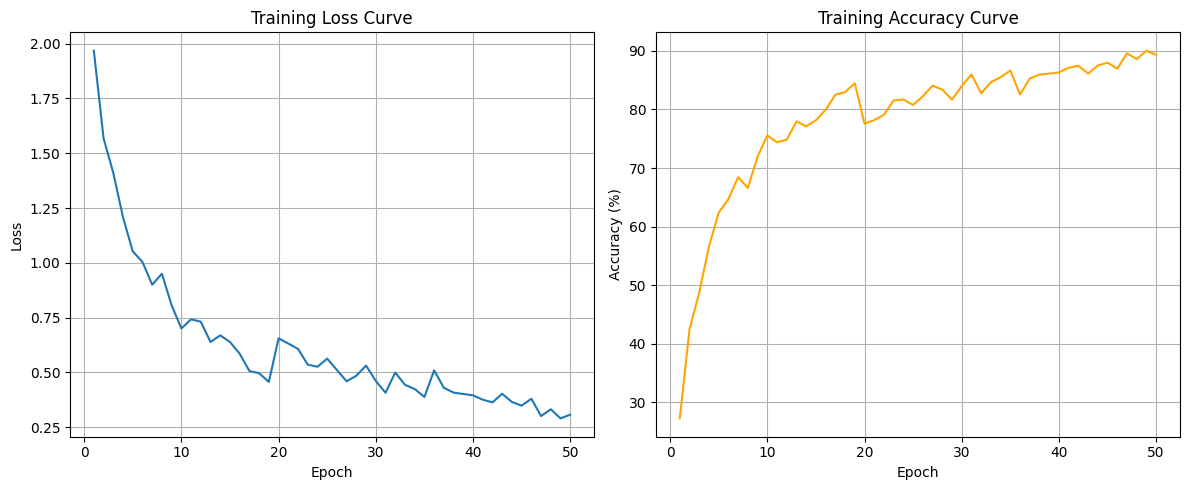

Test Accuracy: 87.38%


In [9]:
model = ResNetNEO3663().to(device)
criterion = nn.CrossEntropyLoss()

optimizer = torch.optim.AdamW(model.parameters(), lr=2e-3, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=20, gamma=0.5)

train_losses, train_accuracies = train(model, optimizer, criterion, epochs=50)
plot_training_curves(train_losses, train_accuracies)
test(model)

In [10]:
torch.save(model.state_dict(), "model_res3663_0.002steplr_50epo.pth")

Epoch 1/50, Loss: 1.7004, Accuracy: 36.51%
Epoch 2/50, Loss: 1.1602, Accuracy: 58.55%
Epoch 3/50, Loss: 0.9125, Accuracy: 68.26%
Epoch 4/50, Loss: 0.7631, Accuracy: 73.66%
Epoch 5/50, Loss: 0.6719, Accuracy: 77.08%
Epoch 6/50, Loss: 0.5973, Accuracy: 79.53%
Epoch 7/50, Loss: 0.5392, Accuracy: 81.67%
Epoch 8/50, Loss: 0.4947, Accuracy: 83.10%
Epoch 9/50, Loss: 0.4563, Accuracy: 84.45%
Epoch 10/50, Loss: 0.4190, Accuracy: 85.65%
Epoch 11/50, Loss: 0.3922, Accuracy: 86.80%
Epoch 12/50, Loss: 0.3667, Accuracy: 87.41%
Epoch 13/50, Loss: 0.3386, Accuracy: 88.66%
Epoch 14/50, Loss: 0.3167, Accuracy: 89.34%
Epoch 15/50, Loss: 0.2949, Accuracy: 89.98%
Epoch 16/50, Loss: 0.2756, Accuracy: 90.56%
Epoch 17/50, Loss: 0.2627, Accuracy: 91.08%
Epoch 18/50, Loss: 0.2422, Accuracy: 91.60%
Epoch 19/50, Loss: 0.2319, Accuracy: 92.11%
Epoch 20/50, Loss: 0.2187, Accuracy: 92.50%
Epoch 21/50, Loss: 0.1999, Accuracy: 93.12%
Epoch 22/50, Loss: 0.1940, Accuracy: 93.33%
Epoch 23/50, Loss: 0.1828, Accuracy: 93.7

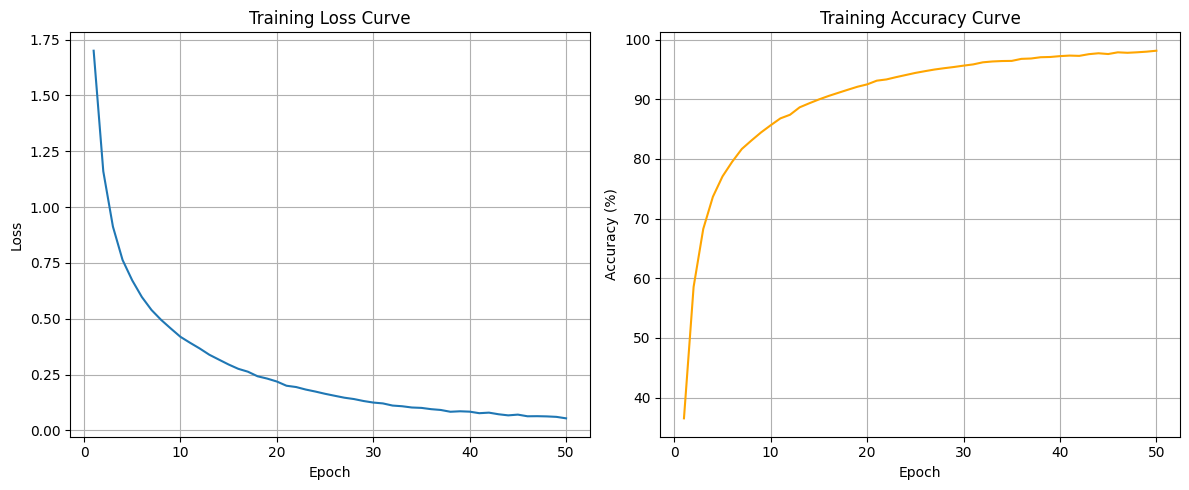

Test Accuracy: 91.27%


In [7]:
model = ResNetNEO3663().to(device)
criterion = nn.CrossEntropyLoss()

optimizer = torch.optim.AdamW(model.parameters(), lr=5e-4, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=20, gamma=0.5)

train_losses, train_accuracies = train(model, optimizer, criterion, epochs=50)
plot_training_curves(train_losses, train_accuracies)
test(model)

In [8]:
torch.save(model.state_dict(), "model_res3663_0.0005steplr_50epo.pth")

In [ ]:
model = ResNetNEO3663().to(device)
criterion = nn.CrossEntropyLoss()

optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=20, gamma=0.5)

train_losses, train_accuracies = train(model, optimizer, criterion, epochs=50)
plot_training_curves(train_losses, train_accuracies)
test(model)

Epoch 1/50, Loss: 1.6000, Accuracy: 40.59%
Epoch 2/50, Loss: 1.0840, Accuracy: 61.07%
Epoch 3/50, Loss: 0.8424, Accuracy: 70.45%
Epoch 4/50, Loss: 0.6815, Accuracy: 76.43%
Epoch 5/50, Loss: 0.5594, Accuracy: 80.76%
Epoch 6/50, Loss: 0.4481, Accuracy: 84.68%
Epoch 7/50, Loss: 0.3561, Accuracy: 87.77%
Epoch 8/50, Loss: 0.2605, Accuracy: 91.02%
Epoch 9/50, Loss: 0.1948, Accuracy: 93.28%
Epoch 10/50, Loss: 0.1412, Accuracy: 95.19%
Epoch 11/50, Loss: 0.1102, Accuracy: 96.23%
Epoch 12/50, Loss: 0.0927, Accuracy: 96.89%
Epoch 13/50, Loss: 0.0772, Accuracy: 97.40%
Epoch 14/50, Loss: 0.0711, Accuracy: 97.63%
Epoch 15/50, Loss: 0.0582, Accuracy: 98.07%
Epoch 16/50, Loss: 0.0530, Accuracy: 98.22%
Epoch 17/50, Loss: 0.0512, Accuracy: 98.31%
Epoch 18/50, Loss: 0.0509, Accuracy: 98.32%
Epoch 19/50, Loss: 0.0400, Accuracy: 98.67%
Epoch 20/50, Loss: 0.0386, Accuracy: 98.70%
Epoch 21/50, Loss: 0.0368, Accuracy: 98.77%
Epoch 22/50, Loss: 0.0378, Accuracy: 98.73%
Epoch 23/50, Loss: 0.0342, Accuracy: 98.8

Epoch 1/50, Loss: 1.7811, Accuracy: 33.21%
Epoch 2/50, Loss: 1.3509, Accuracy: 50.63%
Epoch 3/50, Loss: 1.1079, Accuracy: 60.38%
Epoch 4/50, Loss: 0.9434, Accuracy: 66.90%
Epoch 5/50, Loss: 0.8155, Accuracy: 71.48%
Epoch 6/50, Loss: 0.7265, Accuracy: 75.03%
Epoch 7/50, Loss: 0.6490, Accuracy: 77.79%
Epoch 8/50, Loss: 0.5930, Accuracy: 79.78%
Epoch 9/50, Loss: 0.5410, Accuracy: 81.70%
Epoch 10/50, Loss: 0.5020, Accuracy: 83.02%
Epoch 11/50, Loss: 0.4672, Accuracy: 84.18%
Epoch 12/50, Loss: 0.4355, Accuracy: 85.33%
Epoch 13/50, Loss: 0.4158, Accuracy: 86.11%
Epoch 14/50, Loss: 0.3791, Accuracy: 87.20%
Epoch 15/50, Loss: 0.3581, Accuracy: 87.99%
Epoch 16/50, Loss: 0.3399, Accuracy: 88.53%
Epoch 17/50, Loss: 0.3173, Accuracy: 89.19%
Epoch 18/50, Loss: 0.2989, Accuracy: 89.84%
Epoch 19/50, Loss: 0.2846, Accuracy: 90.34%
Epoch 20/50, Loss: 0.2651, Accuracy: 90.94%
Epoch 21/50, Loss: 0.2518, Accuracy: 91.42%
Epoch 22/50, Loss: 0.2374, Accuracy: 91.89%
Epoch 23/50, Loss: 0.2272, Accuracy: 92.3

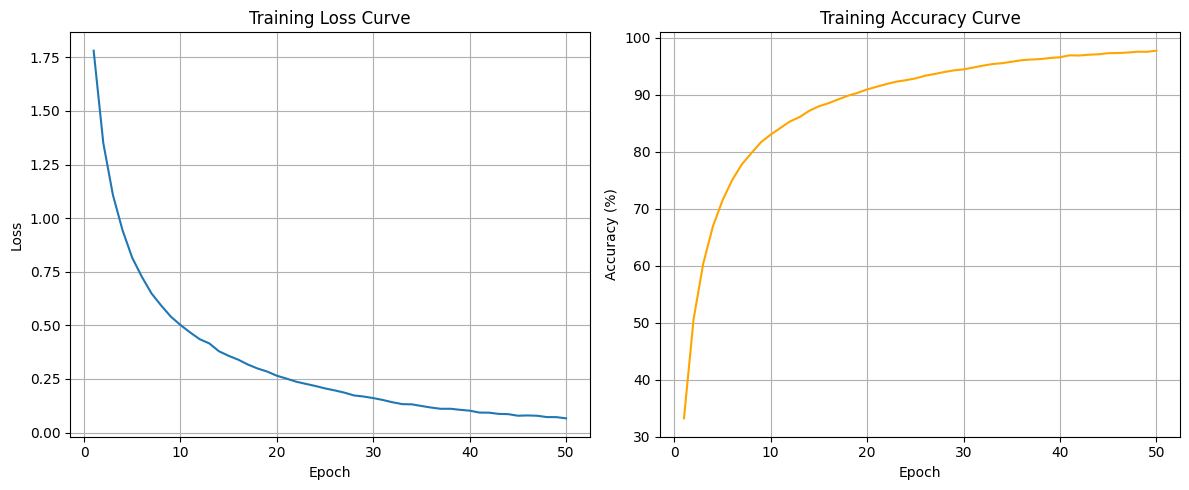

Test Accuracy: 91.30%


In [7]:
model = ResNetNEO3663().to(device)
criterion = nn.CrossEntropyLoss()

optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=20, gamma=0.5)

train_losses, train_accuracies = train(model, optimizer, criterion, epochs=50)
plot_training_curves(train_losses, train_accuracies)
test(model)

In [8]:
torch.save(model.state_dict(), "model_res3663_50epo_clip.pth")

Epoch 1/200, Loss: 1.7320, Accuracy: 35.08%
Epoch 2/200, Loss: 1.2333, Accuracy: 55.47%
Epoch 3/200, Loss: 0.9730, Accuracy: 65.61%
Epoch 4/200, Loss: 0.8124, Accuracy: 71.68%
Epoch 5/200, Loss: 0.7067, Accuracy: 75.66%
Epoch 6/200, Loss: 0.6308, Accuracy: 78.36%
Epoch 7/200, Loss: 0.5691, Accuracy: 80.59%
Epoch 8/200, Loss: 0.5143, Accuracy: 82.64%
Epoch 9/200, Loss: 0.4689, Accuracy: 84.24%
Epoch 10/200, Loss: 0.4347, Accuracy: 85.31%
Epoch 11/200, Loss: 0.4038, Accuracy: 86.29%
Epoch 12/200, Loss: 0.3763, Accuracy: 87.25%
Epoch 13/200, Loss: 0.3462, Accuracy: 88.12%
Epoch 14/200, Loss: 0.3210, Accuracy: 89.20%
Epoch 15/200, Loss: 0.3004, Accuracy: 89.90%
Epoch 16/200, Loss: 0.2907, Accuracy: 90.19%
Epoch 17/200, Loss: 0.2618, Accuracy: 91.10%
Epoch 18/200, Loss: 0.2484, Accuracy: 91.57%
Epoch 19/200, Loss: 0.2301, Accuracy: 92.11%
Epoch 20/200, Loss: 0.2187, Accuracy: 92.46%
Epoch 21/200, Loss: 0.2047, Accuracy: 93.04%
Epoch 22/200, Loss: 0.1877, Accuracy: 93.53%
Epoch 23/200, Loss:

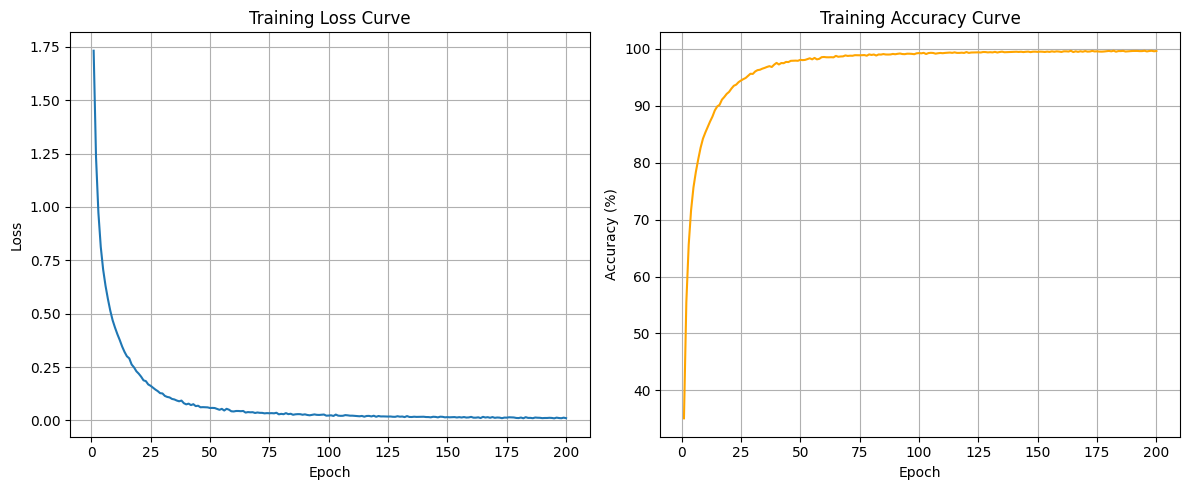

Test Accuracy: 93.08%


In [7]:
model = ResNetNEO3663().to(device)
criterion = nn.CrossEntropyLoss()

optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=20, gamma=0.5)

train_losses, train_accuracies = train(model, optimizer, criterion, epochs=200)
plot_training_curves(train_losses, train_accuracies)
test(model)

In [8]:
torch.save(model.state_dict(), "model_res3663_200epo.pth")

In [7]:
import numpy as np
import torch

def rand_bbox(size, lam):
    W = size[2]
    H = size[3]
    cut_rat = np.sqrt(1. - lam)
    cut_w = int(W * cut_rat)
    cut_h = int(H * cut_rat)

    cx = np.random.randint(W)
    cy = np.random.randint(H)

    bbx1 = np.clip(cx - cut_w // 2, 0, W)
    bby1 = np.clip(cy - cut_h // 2, 0, H)
    bbx2 = np.clip(cx + cut_w // 2, 0, W)
    bby2 = np.clip(cy + cut_h // 2, 0, H)

    return bbx1, bby1, bbx2, bby2


def train(model, optimizer, criterion, train_loader, device, epochs=30, scheduler=None, cutmix_prob=0.5):
    model.train()
    train_losses = []
    train_accuracies = []

    for epoch in range(epochs):
        running_loss = 0.0
        correct = 0
        total = 0

        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()

            # === CutMix ===
            r = np.random.rand(1)
            if r < cutmix_prob:
                lam = np.random.beta(1.0, 1.0)
                rand_index = torch.randperm(inputs.size()[0]).to(device)
                target_a = labels
                target_b = labels[rand_index]
                bbx1, bby1, bbx2, bby2 = rand_bbox(inputs.size(), lam)
                inputs[:, :, bbx1:bbx2, bby1:bby2] = inputs[rand_index, :, bbx1:bbx2, bby1:bby2]
                lam = 1 - ((bbx2 - bbx1) * (bby2 - bby1) / (inputs.size(-1) * inputs.size(-2)))
                outputs = model(inputs)
                loss = criterion(outputs, target_a) * lam + criterion(outputs, target_b) * (1. - lam)
            else:
                outputs = model(inputs)
                loss = criterion(outputs, labels)

            loss.backward()
            optimizer.step()

            running_loss += loss.item() * inputs.size(0)
            _, predicted = outputs.max(1)
            correct += predicted.eq(labels).sum().item()
            total += labels.size(0)

        if scheduler:
            scheduler.step()

        epoch_loss = running_loss / total
        epoch_acc = correct / total

        train_losses.append(epoch_loss)
        train_accuracies.append(epoch_acc)

        print(f"Epoch [{epoch + 1}/{epochs}]  Loss: {epoch_loss:.4f}  Accuracy: {epoch_acc:.4f}")

    return train_losses, train_accuracies

In [8]:
!pip install torch_optimizer

Looking in indexes: http://mirrors.aliyun.com/pypi/simple


Epoch [1/200]  Loss: 1.8196  Accuracy: 0.3297
Epoch [2/200]  Loss: 1.3583  Accuracy: 0.5281
Epoch [3/200]  Loss: 1.1649  Accuracy: 0.6089
Epoch [4/200]  Loss: 1.0265  Accuracy: 0.6692
Epoch [5/200]  Loss: 0.9239  Accuracy: 0.7033
Epoch [6/200]  Loss: 0.8513  Accuracy: 0.7303
Epoch [7/200]  Loss: 0.8404  Accuracy: 0.7326
Epoch [8/200]  Loss: 0.7536  Accuracy: 0.7624
Epoch [9/200]  Loss: 0.7313  Accuracy: 0.7718
Epoch [10/200]  Loss: 0.6939  Accuracy: 0.7853
Epoch [11/200]  Loss: 0.6621  Accuracy: 0.7928
Epoch [12/200]  Loss: 0.6435  Accuracy: 0.7933
Epoch [13/200]  Loss: 0.5855  Accuracy: 0.8146
Epoch [14/200]  Loss: 0.6055  Accuracy: 0.8112
Epoch [15/200]  Loss: 0.5761  Accuracy: 0.8203
Epoch [16/200]  Loss: 0.5399  Accuracy: 0.8273
Epoch [17/200]  Loss: 0.5267  Accuracy: 0.8359
Epoch [18/200]  Loss: 0.4968  Accuracy: 0.8437
Epoch [19/200]  Loss: 0.4904  Accuracy: 0.8457
Epoch [20/200]  Loss: 0.4864  Accuracy: 0.8504
Epoch [21/200]  Loss: 0.4729  Accuracy: 0.8512
Epoch [22/200]  Loss: 

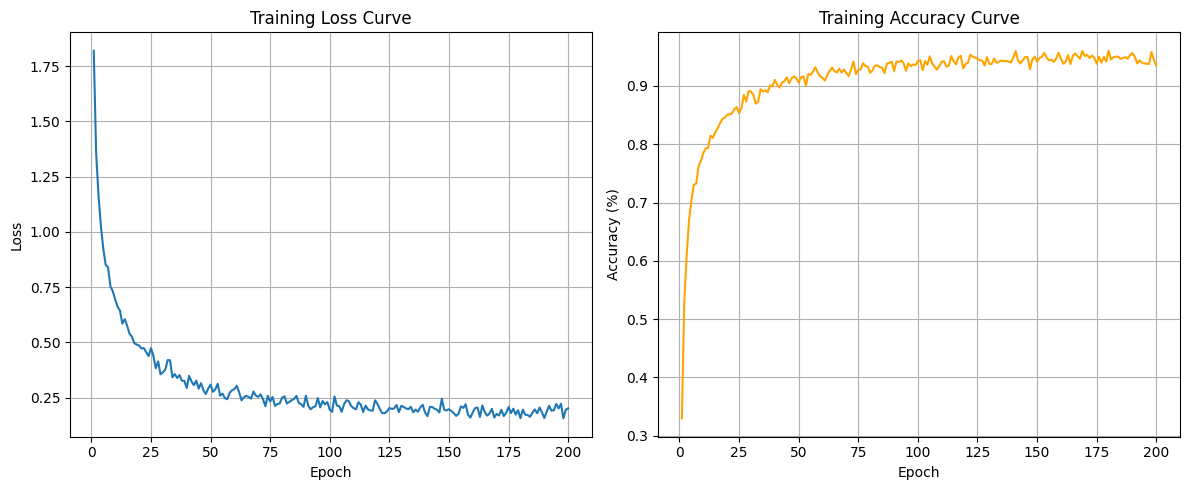

Test Accuracy: 94.39%


In [11]:
import torch_optimizer as optim
from torch.optim.lr_scheduler import CosineAnnealingLR

model = ResNetNEO3663().to(device)
criterion = nn.CrossEntropyLoss()

base_optim = torch.optim.AdamW(model.parameters(), lr=1e-3, weight_decay=1e-4)
optimizer = optim.Lookahead(base_optim, k=5, alpha=0.5)
scheduler = CosineAnnealingLR(optimizer, T_max=200, eta_min=1e-6)

train_losses, train_accuracies = train(
    model,
    optimizer,
    criterion,
    trainloader,
    device,
    epochs=200,
    scheduler=scheduler,
    cutmix_prob=0.2
)

plot_training_curves(train_losses, train_accuracies)
test(model)

In [12]:
torch.save(model.state_dict(), "model_res3663_200epo_cutmix_sche.pth")

Epoch [1/200]  Loss: 1.7868  Accuracy: 0.3444
Epoch [2/200]  Loss: 1.3093  Accuracy: 0.5458
Epoch [3/200]  Loss: 1.1083  Accuracy: 0.6311
Epoch [4/200]  Loss: 0.9765  Accuracy: 0.6797
Epoch [5/200]  Loss: 0.9110  Accuracy: 0.7108
Epoch [6/200]  Loss: 0.8634  Accuracy: 0.7207
Epoch [7/200]  Loss: 0.7829  Accuracy: 0.7474
Epoch [8/200]  Loss: 0.7457  Accuracy: 0.7572
Epoch [9/200]  Loss: 0.7033  Accuracy: 0.7775
Epoch [10/200]  Loss: 0.6564  Accuracy: 0.7909
Epoch [11/200]  Loss: 0.6418  Accuracy: 0.7961
Epoch [12/200]  Loss: 0.5939  Accuracy: 0.8162
Epoch [13/200]  Loss: 0.5891  Accuracy: 0.8160
Epoch [14/200]  Loss: 0.5532  Accuracy: 0.8207
Epoch [15/200]  Loss: 0.5599  Accuracy: 0.8227
Epoch [16/200]  Loss: 0.5230  Accuracy: 0.8359
Epoch [17/200]  Loss: 0.4902  Accuracy: 0.8442
Epoch [18/200]  Loss: 0.4750  Accuracy: 0.8524
Epoch [19/200]  Loss: 0.4737  Accuracy: 0.8578
Epoch [20/200]  Loss: 0.4764  Accuracy: 0.8476
Epoch [21/200]  Loss: 0.4562  Accuracy: 0.8604
Epoch [22/200]  Loss: 

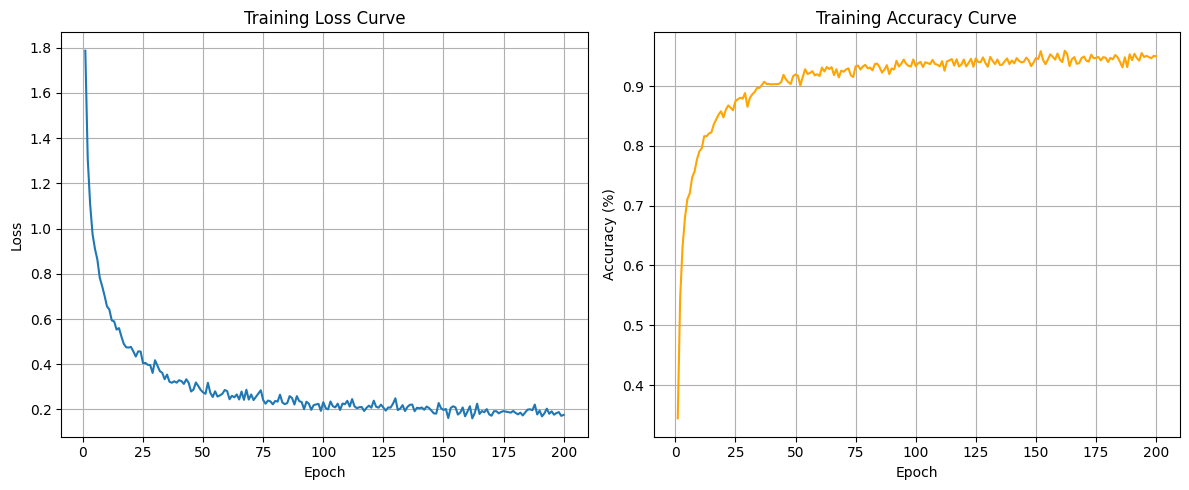

Test Accuracy: 94.45%


In [9]:
import torch_optimizer as optim
from torch.optim.lr_scheduler import CosineAnnealingLR

model = ResNetNEO3663().to(device)
criterion = nn.CrossEntropyLoss()

base_optim = torch.optim.AdamW(model.parameters(), lr=1e-3, weight_decay=1e-4)
optimizer = optim.Lookahead(base_optim, k=5, alpha=0.5)
scheduler = CosineAnnealingLR(optimizer, T_max=200, eta_min=3e-4)

train_losses, train_accuracies = train(
    model,
    optimizer,
    criterion,
    trainloader,
    device,
    epochs=200,
    scheduler=scheduler,
    cutmix_prob=0.2
)

plot_training_curves(train_losses, train_accuracies)
test(model)

In [ ]:
torch.save(model.state_dict(), "model_res3663_200epo_cutmix_sche_neo.pth")

In [8]:

model = ResNetNEO3663().to(device)
model.load_state_dict(torch.load(r"D:/Chrome Download/model_res3663_200epo_cutmix_sche_neo.pth", map_location=device))
model.eval()


C:\Users\Yeche\AppData\Local\Temp\ipykernel_88228\2945989380.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(r"D:/Chrome Download/model_

ResNetNEO3663(
  (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU()
  (layer1): Sequential(
    (0): ResidualBlock(
      (conv1): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (bn1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (shortcut): Sequential(
        (0): Conv2d(64, 128, kernel_size=(1, 1), stride=(2, 2))
        (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (1): ResidualBlock(
      (conv1): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affin

In [9]:
import matplotlib.pyplot as plt
import torchvision

def visualize_conv1_weights(model):
    with torch.no_grad():
        weights = model.conv1.weight.cpu().clone()  # shape: [C_out, C_in, H, W]
        grid = torchvision.utils.make_grid(weights, nrow=8, normalize=True, pad_value=1)
        plt.figure(figsize=(8, 8))
        plt.imshow(grid.permute(1, 2, 0))  # CHW → HWC
        plt.title("Conv1 Filters")
        plt.axis('off')
        plt.show()


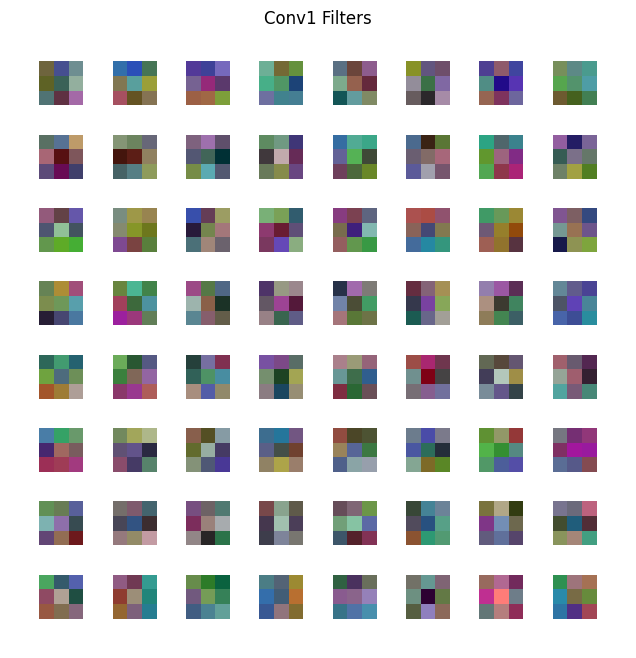

In [10]:
visualize_conv1_weights(model)

In [11]:
def visualize_feature_maps(model, input_tensor, layer='conv1'):
    model.eval()
    input_tensor = input_tensor.unsqueeze(0).to(next(model.parameters()).device)  # [1, 3, 32, 32]

    with torch.no_grad():
        x = input_tensor
        activations = None

        # 支持不同层名称，默认是 'conv1'
        if layer == 'conv1':
            activations = model.conv1(x)
        elif layer == 'layer1':
            x = model.conv1(x)
            x = model.bn1(x)
            x = model.relu(x)
            activations = model.layer1(x)
        else:
            raise ValueError("Unsupported layer name")

        fmap = activations[0].cpu()  # shape: [C, H, W]

        # 可视化前6张特征图
        num_maps = min(6, fmap.shape[0])
        fig, axs = plt.subplots(1, num_maps, figsize=(15, 5))
        for i in range(num_maps):
            axs[i].imshow(fmap[i], cmap='viridis')
            axs[i].axis('off')
        plt.suptitle(f'Feature Maps from {layer}', fontsize=16)
        plt.show()


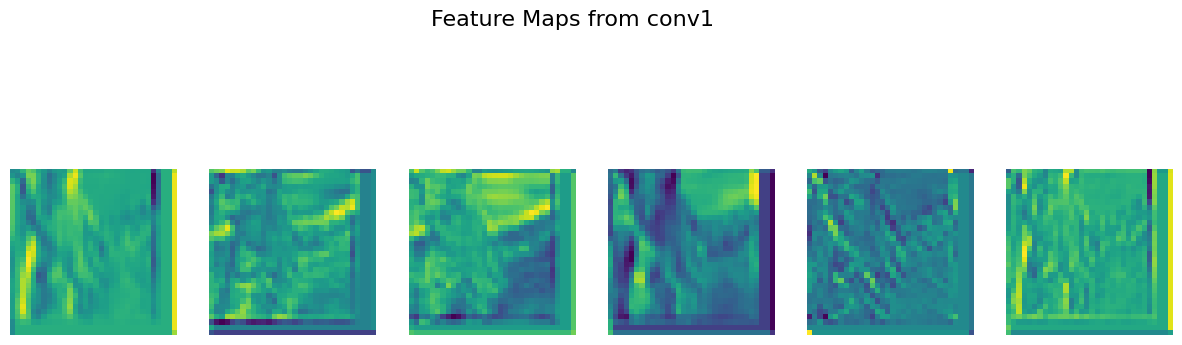

In [12]:
# 先准备一张图像 tensor，例如从 dataloader 中取：
images, labels = next(iter(trainloader))
img = images[0]  # 取一张图片

# 然后可视化：
visualize_feature_maps(model, img, layer='conv1')  # 或 'layer1'


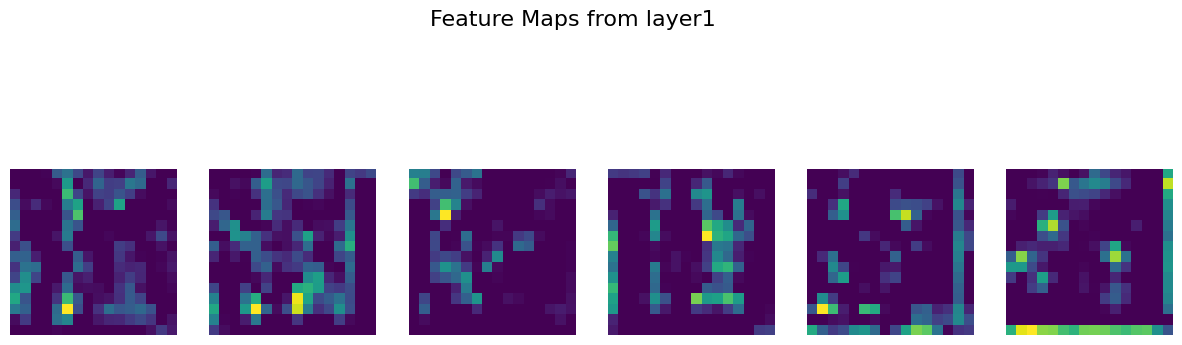

In [13]:
visualize_feature_maps(model, img, layer='layer1')